In [5]:
import numpy as np
import pandas as pd  
import xarray as xr 
import matplotlib.pyplot as plt 

In [6]:
def get_phase(RMM1, RMM2):
    if RMM1>=0 and RMM2>=0 and RMM1>=RMM2:
        return 5
    elif RMM1>=0 and RMM2>=0 and RMM1<=RMM2:
        return 6
    elif RMM1<=0 and RMM2>=0 and -RMM1<=RMM2:
        return 7
    elif RMM1<=0 and RMM2>=0 and -RMM1>=RMM2:
        return 8 
    elif RMM1<=0 and RMM2<=0 and RMM1<=RMM2:
        return 1
    elif RMM1<=0 and RMM2<=0 and RMM1>=RMM2:
        return 2 
    elif RMM1>=0 and RMM2<=0 and RMM1<=-RMM2:
        return 3
    elif RMM1>=0 and RMM2<=0 and RMM1>=-RMM2:
        return 4

In [7]:
def get_BCC_RMSE(m, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=1, Inipha_list=np.arange(1,9)):
    # analyze error source
    RMSE = []
    amp_err  = []
    pha_err = []
    BCC = []

    # define the selected time series, inclusive
    tsta = np.datetime64(str(testyrsta)) + np.timedelta64(nmem-1, 'D')
    tend = np.datetime64(str(testyrend)) - np.timedelta64(1, 'D')

    # RMM index in all seasons, amplitudes and phases.
    fnRMM = '/pscratch/sd/l/linyaoly/ERA5/reanalysis/rmm/full/RMM_ERA5_daily_1901to2020.nc'
    dsrmm0 = xr.open_dataset(fnRMM)
    # delete doy 366
    # dsrmm0 = dsrmm1.where(dsrmm1.time.dt.dayofyear!=366, drop=True)    
    dsrmm = dsrmm0.sel(time=slice(tsta, tend))

    
    RMMi1 = dsrmm['RMM'][:,0]
    RMMi2 = dsrmm['RMM'][:,1]

    # calculate initial amplitude
    Iniamp = (RMMi1 * RMMi1 + RMMi2 * RMMi2)**(1/2)

    # calculate initial phase
    Inipha = np.zeros(len(RMMi1))

    for i in np.arange(len(RMMi1)):
        Inipha[i] = get_phase(RMMi1[i].values,RMMi2[i].values)
     
    Inipha = xr.DataArray(
        data=Inipha,
        dims=['time'],
        coords=dict(
            time=Iniamp.time,
        ),
    ) 

    time_len0 = len(Iniamp.time)

    for ilead, leadmjo in zip(np.arange(len(lead)), lead): 

        fn = './output/predicted_MCDO_UNET_olr20deg_RMMERA5_'+str(m)+'modes_lead'+str(leadmjo)+'_dailyinput_1979to2015_mem'+str(nmem)+'d.nc'

        dsfn0 = xr.open_dataset(fn)
        dsfn = dsfn0.sel(time=slice(tsta, tend))

        # RMMp, RMMt, RMMp_dis in all seasons, amplitudes and phases. 
        # add Initial amplitude and phase information into the dataset.

        # check whether they have the same length.
        time_len1 = len(dsfn['time'])

        assert time_len0 == time_len1, f"Time lengths in RMM raw file and predcition are different"

        # assign variables to dsfn
        dsfn = dsfn.assign(IniAmp=Iniamp)
        dsfn = dsfn.assign(IniPha=Inipha)
        dsfn['RMMt'][:] = dsrmm0.sel(time=slice(tsta+np.timedelta64(leadmjo, 'D'), tend+np.timedelta64(leadmjo, 'D')))['RMM'].values

        # select a subset of dsfn based on seasons, Initial amplitude threshold and initial phase. 
        # mask_season = pd.to_datetime(dsfn.time).month.isin(season_list)
        mask_season = dsfn.time.dt.month.isin(season_list)
        mask_Iniamp = dsfn.IniAmp >= Iniamp0
        mask_Inipha = dsfn.IniPha.isin(Inipha_list)

        mask = mask_season & mask_Iniamp & mask_Inipha

        dsfn_sel = dsfn.where(mask, drop=True)

        # calculate BCC for each MCDO
        r1p = np.asarray(dsfn_sel['RMMp'][:,0]).reshape((-1, 1))
        r2p = np.asarray(dsfn_sel['RMMp'][:,1]).reshape((-1, 1))

        r1t = np.asarray(dsfn_sel['RMMt'][:,0]).reshape((-1, 1))
        r2t = np.asarray(dsfn_sel['RMMt'][:,1]).reshape((-1, 1))

        # # calculate BCC for each MCDO
        # r1p = np.asarray(dsfn_sel['RMMp'][:,0])
        # r2p = np.asarray(dsfn_sel['RMMp'][:,1])

        # r1t = np.asarray(dsfn_sel['RMMt'][:,0])
        # r2t = np.asarray(dsfn_sel['RMMt'][:,1])

        # print(np.shape(r1p))
        # print(np.shape(r2t))

        # BCC  [Nsamp]
        a = np.sum(r1p*r1t+r2p*r2t, axis=0)
        b = np.sqrt(np.sum(r1t*r1t+r2t*r2t, axis=0))
        c = np.sqrt(np.sum(r1p*r1p+r2p*r2p, axis=0))
        BCC.append(a/b/c) 

        # RMSE [time, Nsamp]
        d = (r1t-r1p)*(r1t-r1p)+(r2t-r2p)*(r2t-r2p)
        RMSE.append(np.sqrt(d))  # RMSE at each time step

        # phase error [time, Nsamp]
        a = r1t * r2p - r2t * r1p 
        b = r1t * r1p + r2t * r2p
        c = a / b 
        d = np.arctan(c) * 180. / np.pi
        pha_err.append(d)

        # amplitude error [time, Nsamp] truth - prediction
        a = np.sqrt(r1p*r1p+r2p*r2p)
        b = np.sqrt(r1t*r1t+r2t*r2t)
        c = b - a 
        amp_err.append(c)

        del dsfn 
        del dsfn_sel

    return BCC, RMSE, pha_err, amp_err

In [8]:
lead = [10]   # select the prediction lead
testyrsta = 2015
testyrend = 2020
nmem = 1
Iniamp0 = 0

BCC = []
for m in np.arange(1,6):
    BCC0, RMSE, pha_err, amp_err = get_BCC_RMSE(m, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
    # print(BCC0)  
    BCC.append(np.mean(BCC0))

print(BCC)

[0.4954404051789419, 0.5345619882184118, 0.5710143202452406, 0.5549156350614246, 0.5750879104232839]


In [4]:
lead = [1, 5, 10, 13, 15, 20, 25, 30]   # select the prediction lead
testyrsta = 2015
testyrend = 2020
nmem = 1
BCC = []
RMSE = []
pha_err = []
amp_err = []

for m in np.arange(1,6):
    BCC1, RMSE1, pha_err1, amp_err1 = get_BCC_RMSE(m, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=0, Inipha_list=np.arange(1,9))
    BCC.append(BCC1)
    RMSE.append(RMSE1)
    pha_err.append(pha_err1)
    amp_err.append(amp_err1)



In [5]:
def get_figure(ax, lead, BCC, label_flg, RMSE, amp_err, pha_err):
    ax[0,0].plot(lead, BCC, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    # ax[0,0].plot(lead, BCCw, 'o-', linewidth=3, label='DJFM, Iniamp>1, All Inipha')
    ax[0,0].plot(lead, 0.5 * np.ones(len(lead)), '--', color='k')
    ax[0,0].grid(visible=True)
    ax[0,0].set_xlabel('lead (days)')
    ax[0,0].set_ylabel('BCC')
    # ax[0,0].legend()

    avRMSE = np.mean(RMSE, axis=1)
    # avRMSEw = np.mean(RMSEw, axis=1)

    ax[0,1].plot(lead, avRMSE, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    # ax[0,1].plot(lead, avRMSEw, 'o-', linewidth=3, label='DJFM, Iniamp>1, All Inipha')
    ax[0,1].plot(lead, 1.2 * np.ones(len(lead)), '--', color='k')
    ax[0,1].grid(visible=True)
    ax[0,1].set_xlabel('lead (days)')
    ax[0,1].set_ylabel('RMSE')
    ax[0,1].legend(fontsize=12)

    avamperr = np.mean(amp_err, axis=1)
    # avamperr = np.mean(amp_err, axis=1)

    ax[1,1].plot(lead, avamperr, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    # ax[0,1].plot(lead, 1.2 * np.ones(len(lead)))
    ax[1,1].grid(visible=True)
    ax[1,1].set_xlabel('lead (days)')
    ax[1,1].set_ylabel('Amplitude Error')
    # ax[1,1].legend()

    avphaerr = np.mean(pha_err, axis=1)

    ax[1,0].plot(lead, avphaerr, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    # ax[0,1].plot(lead, 1.2 * np.ones(len(lead)))
    ax[1,0].grid(visible=True)
    ax[1,0].set_xlabel('lead (days)')
    ax[1,0].set_ylabel('Phase Error (degree)')
    ax[1,0].set_ylim([-15, 15])
    # ax[1,0].legend()

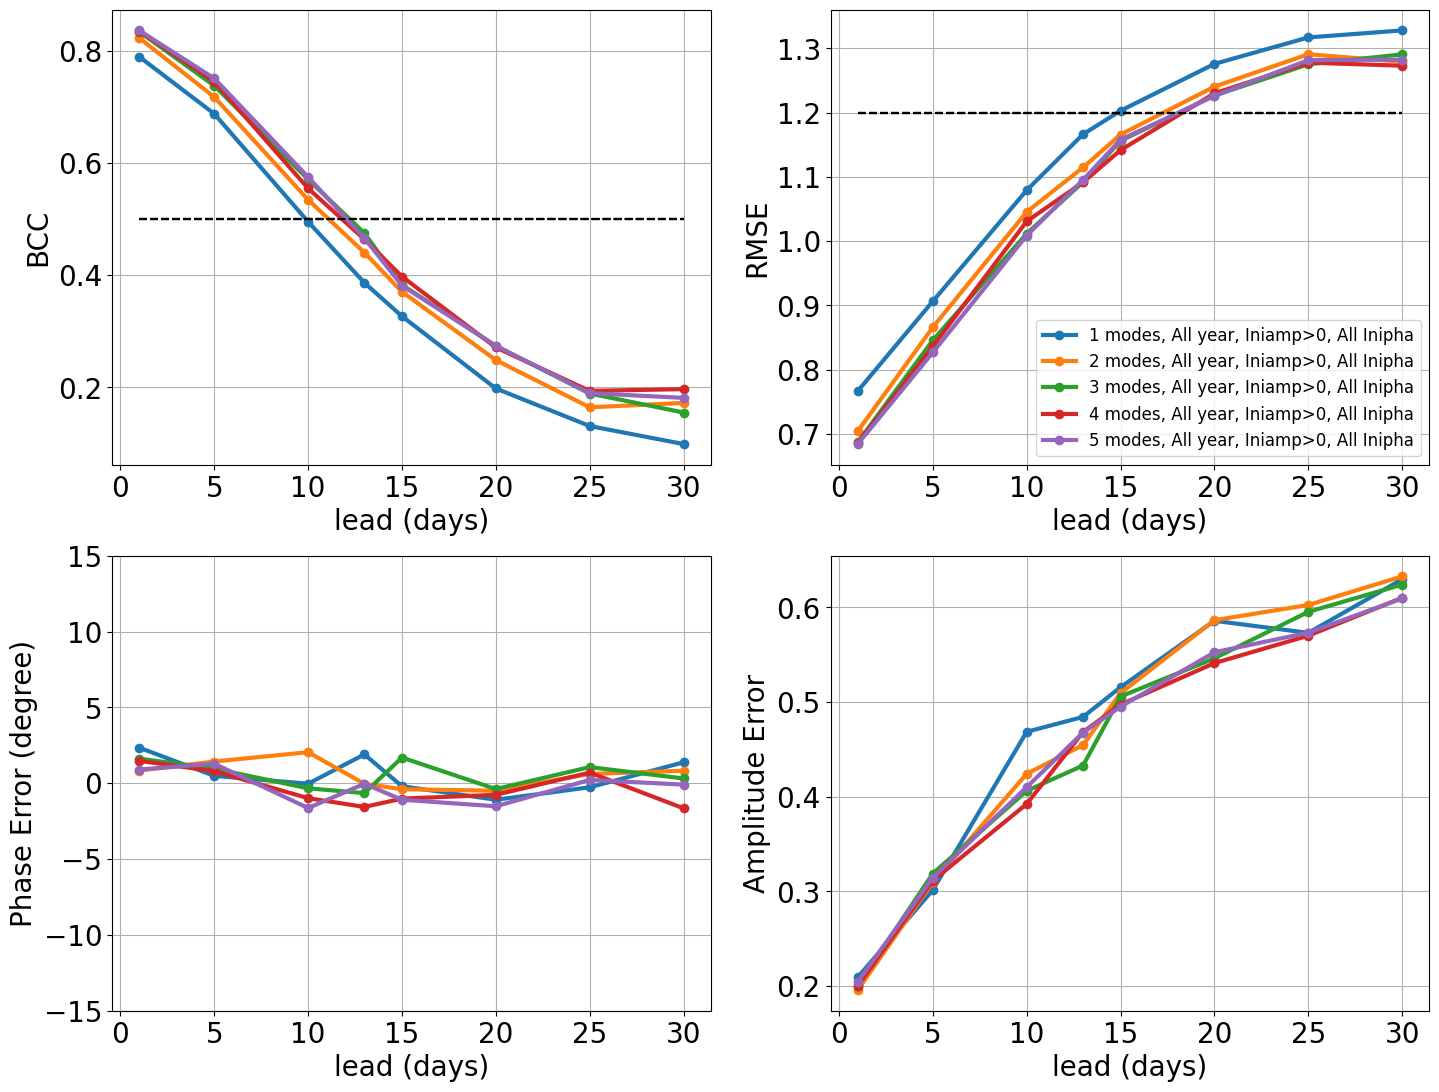

In [6]:
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(17,13))
gs = fig.add_gridspec(2, 2, hspace=0.2, wspace=0.2)
ax = gs.subplots()
plt.rcParams.update({'font.size': 20})

# get_figure(ax, lead, BCCw0, 'winter, Iniamp>0, All Inipha', RMSEw0, amp_errw0, pha_errw0)
# get_figure(ax, lead, BCCs0, 'summer, Iniamp>0, All Inipha', RMSEs0, amp_errs0, pha_errs0)

# get_figure(ax, lead, BCC0, 'All year, Iniamp>0, All Inipha', RMSE0, amp_err0, pha_err0)
for m in np.arange(1,6):
    get_figure(ax, lead, BCC[m-1], str(m)+' modes, All year, Iniamp>0, All Inipha', RMSE[m-1], amp_err[m-1], pha_err[m-1])
# get_figure(ax, lead, BCCw, 'winter, Iniamp>1, All Inipha', RMSEw, amp_errw, pha_errw)
# get_figure(ax, lead, BCCs, 'summer, Iniamp>1, All Inipha', RMSEs, amp_errs, pha_errs)
# get_figure(ax, lead, BCCw2, 'winter, Iniamp>2, All Inipha', RMSEw2, amp_errw2, pha_errw2)
# get_figure(ax, lead, BCCs2, 'summer, Iniamp>2, All Inipha', RMSEs2, amp_errs2, pha_errs2)

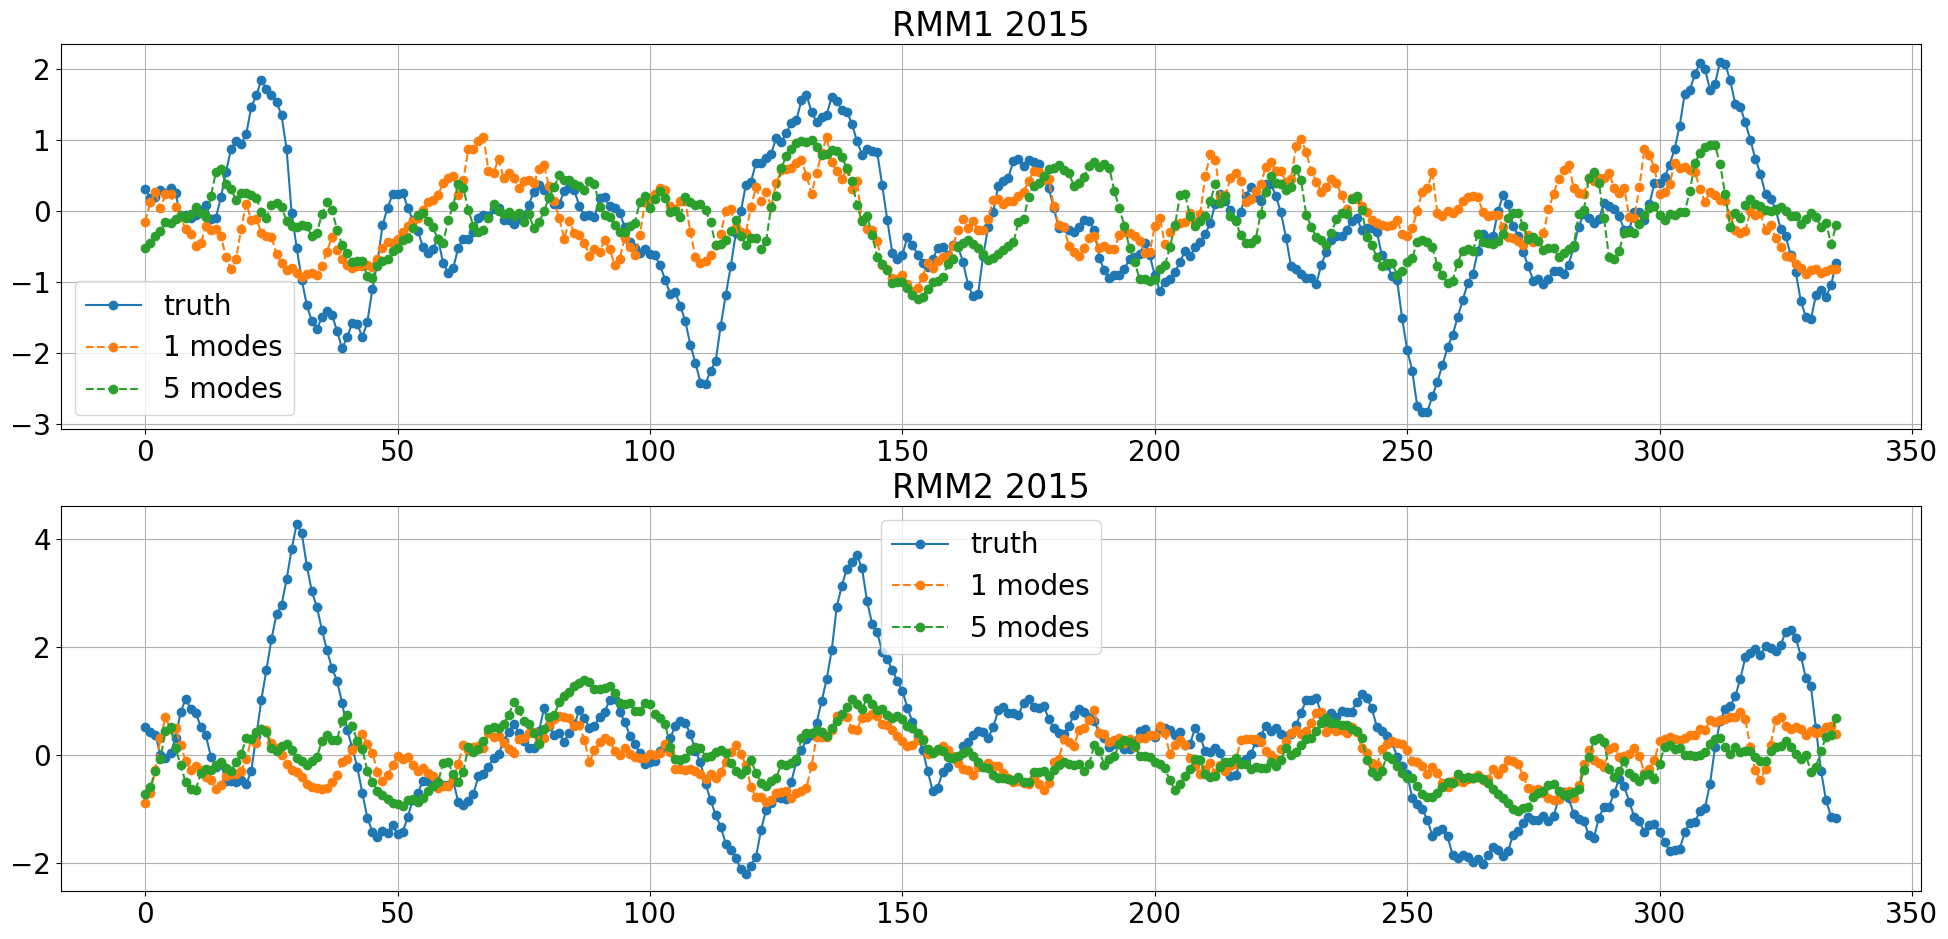

In [17]:
yr = 2015
lead = 15
nmem = 30 
Iniamp0 = 1

fig = plt.figure(figsize=(24,11))
gs = fig.add_gridspec(2, 1, hspace=0.2, wspace=0.2)
ax = gs.subplots()
plt.rcParams.update({'font.size': 20})

m=5
fn = './output/predicted_MCDO_UNET_olr20deg_RMMERA5_'+str(m)+'modes_lead15_dailyinput_1979to2015_mem30d.nc'
ds = xr.open_dataset(fn)

ds15 = ds.sel(time=slice(str(yr)+'-01-01',str(yr)+'-12-31'))
ax[0].plot(ds15['RMMt'][:,0],'o-', label='truth')
ax[1].plot(ds15['RMMt'][:,1],'o-', label='truth')

for m in [1,5]:
    fn = './output/predicted_MCDO_UNET_olr20deg_RMMERA5_'+str(m)+'modes_lead15_dailyinput_1979to2015_mem30d.nc'
    ds = xr.open_dataset(fn)

    ds15 = ds.sel(time=slice(str(yr)+'-01-01',str(yr)+'-12-31'))

    
    ax[0].plot(ds15['RMMp'][:,0],'o--', label=str(m)+' modes')
    
    ax[0].grid(visible=True)
    ax[0].set_title('RMM1 '+ str(yr))

    
    ax[1].plot(ds15['RMMp'][:,1],'o--', label=str(m)+' modes')
    
    ax[1].grid(visible=True)
    ax[1].set_title('RMM2 '+ str(yr))

ax[0].legend()
ax[1].legend()

Text(0.5, 1.0, 'RMM2 2015')

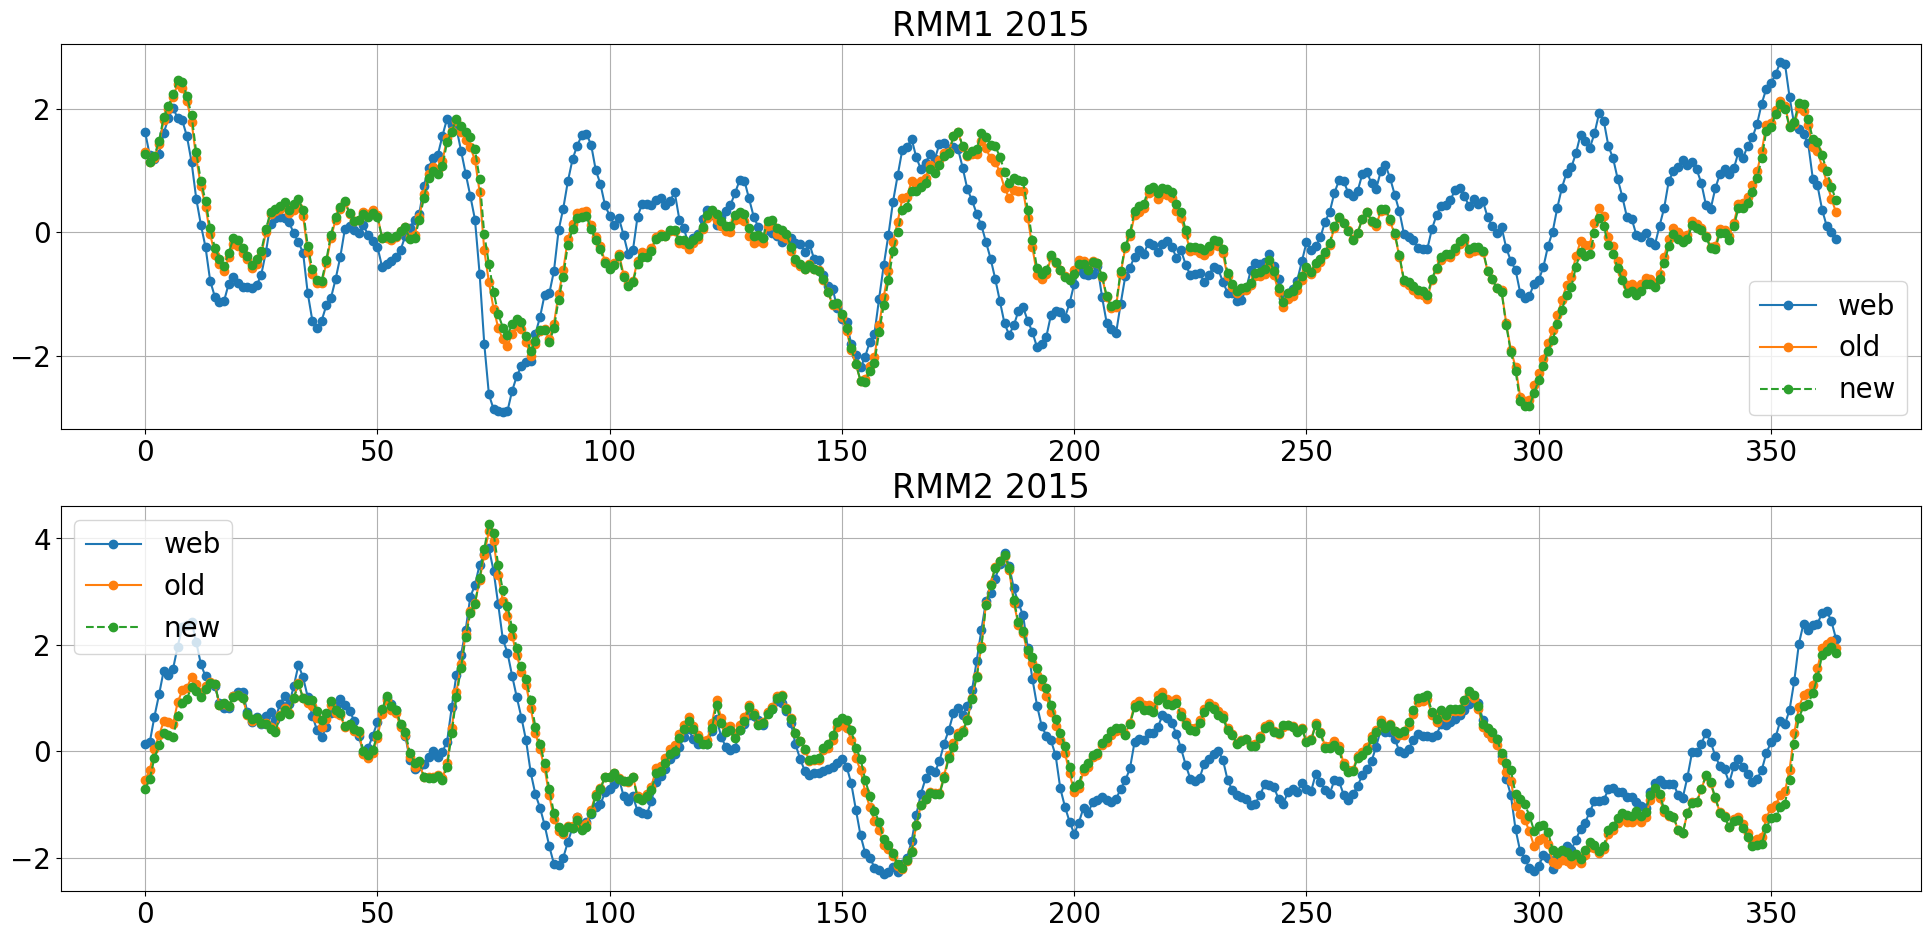

In [6]:
import pandas as pd 
# compare old RMM, new RMM with website RMM in 1979-2020 
fn1 = '/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_daily.nc'
fn2 = '/pscratch/sd/l/linyaoly/ERA5/reanalysis/rmm/full/RMM_ERA5_daily_1901to2020.nc'
ds1 = xr.open_dataset(fn1)
ds2 = xr.open_dataset(fn2)

yr = 2015
ds115 = ds1.sel(time=slice(str(yr)+'-01-01',str(yr)+'-12-31'))
ds215 = ds2.sel(time=slice(str(yr)+'-01-01',str(yr)+'-12-31'))

fn3 = '/global/homes/l/linyaoly/ERA5/reanalysis/realRMM/'+str(yr)+'.csv'
ds3 = pd.read_csv(fn3, sep=',', header=0)

fig = plt.figure(figsize=(24,11))
gs = fig.add_gridspec(2, 1, hspace=0.2, wspace=0.2)
ax = gs.subplots()
plt.rcParams.update({'font.size': 20})

ax[0].plot(ds3['RMM1'],'o-', label='web')
ax[0].plot(ds115['RMM'][:,0],'o-', label='old')
ax[0].plot(ds215['RMM'][:,0],'o--', label='new')

ax[0].legend()
ax[0].grid(visible=True)
ax[0].set_title('RMM1 '+ str(yr))

ax[1].plot(ds3['RMM2'],'o-', label='web')
ax[1].plot(ds115['RMM'][:,1],'o-', label='old')
ax[1].plot(ds215['RMM'][:,1],'o--', label='new')
ax[1].legend()
ax[1].grid(visible=True)
ax[1].set_title('RMM2 '+ str(yr))